In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
import re
import torch
import tqdm
import pandas as pd
import tqdm 
from transformers import BertModel, BertTokenizer
import pandas as pd
import pickle as pkl
import datasets 
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel
btok = AutoTokenizer.from_pretrained('bert-base-uncased')
bmod = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False)
model = BertModel.from_pretrained("wukevin/tcr-bert")

# if torch.cuda.is_available():
model.to('cuda')
model = model.half()


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dfetr=pd.read_csv('./data/BAP/epi_split/train.csv', header=None)
dfete=pd.read_csv('./data/BAP/epi_split/test.csv', header=None)
dfetr.columns = ['Epitope', 'TCR', 'Label']
dfete.columns = ['Epitope', 'TCR', 'Label']

dfttr=pd.read_csv('./data/BAP/tcr_split/train.csv', header=None)
dftte=pd.read_csv('./data/BAP/tcr_split/test.csv', header=None)
dfttr.columns = ['Epitope', 'TCR', 'Label']
dftte.columns = ['Epitope', 'TCR', 'Label']


dfho_epi=pd.read_csv('./data/true_hold_out/epitope_split_test.csv', header=None)
dfho_tcr=pd.read_csv('./data/true_hold_out/tcr_split_test.csv', header=None)
dfho_epi.columns = ['Epitope', 'TCR'] 
dfho_tcr.columns = ['Epitope', 'TCR']

dfemb=pd.read_csv('./data/embedding/TCRrepertoires.csv', header=None)


In [4]:
print('Maximum combined TCR + epitope length')
print(max(np.array(dfetr.TCR.str.len()+dfetr.Epitope.str.len()+3)))

print('Maximum epitope length')
print(max(dfttr.Epitope.str.len()))


print('Maximum TCr length')
print(max(dftte.TCR.str.len()))

print("Maximum Tokenized length for joint seq, will be cut down to 64 because that's maxlen for the bert model")
asdf = ' '.join(['*']+['A']*68+['|', '|'])
# len(asdf)
print(len(tokenizer(asdf)['input_ids']))


print('Maximum Epitope tokenized length')
asdf = ' '.join(['*']+['A']*43+['|', '|'])
print(len(tokenizer(asdf)['input_ids']))


print('Maximum TCR tokenized length')
asdf = ' '.join(['*']+['A']*36+['|', '|'])
len(tokenizer(asdf)['input_ids'])


Maximum combined TCR + epitope length
68
Maximum epitope length
43
Maximum TCr length
36
Maximum Tokenized length for joint seq, will be cut down to 64 because that's maxlen for the bert model
73
Maximum Epitope tokenized length
48
Maximum TCR tokenized length


41

In [5]:
class BindingDataset:
    def __init__(self, inputdf: pd.DataFrame):
        self.epi = inputdf.Epitope.values
        self.tcr = inputdf.TCR.values

        if 'Label' in inputdf.columns:
            self.label = inputdf.Label.values
        else:
            self.label = None
            
    def return_as_dict(self) -> dict:
        if self.label is not None:
            return {'Epitopes': self.epi, 'TCR': self.tcr, 'Labels': self.label}
        else: 
            return {'Epitopes': self.epi, 'TCR': self.tcr}
    
    def return_as_datasets(self) -> Dataset:
        return Dataset.from_dict(self.return_as_dict())
    
    def __len__(self):
        return len(self.epi)

    def __getitem__(self, idx):
        if self.label is not None:
            return self.epi[idx], self.tcr[idx], self.label[idx]
        else:
            return self.epi[idx], self.tcr[idx]

In [6]:
def cls_sep_sep_proc_for_tokenize_tcrbert(inp_sequences_dict, tokenizer, split=None):
    epis = inp_sequences_dict['Epitopes']
    tcrs = inp_sequences_dict['TCR']

    #TODO: figure out if the split is 'tcr' or 'epi' whether TCR or epi should come first
#     seqs =  [f'{tokenizer.cls_token}{_tcr}{tokenizer.sep_token}{_epi}{tokenizer.sep_token}' for _epi, _tcr in zip(epis, tcrs)]
    seqs =  [f"{tokenizer.cls_token} {' '.join(_tcr)} {tokenizer.sep_token} {' '.join(_epi)} {tokenizer.sep_token}" for _epi, _tcr in zip(epis, tcrs)]
    return seqs

def single_sep_proc_for_tokenize_tcrbert(inp_sequences_dict, tokenizer, cls=True):
    epis = inp_sequences_dict['Epitopes']
    tcrs = inp_sequences_dict['TCR']
   
    epi_seqs =  [f"{tokenizer.cls_token} {' '.join(_epi)} {tokenizer.sep_token}" for _epi, _tcr in zip(epis, tcrs)]
    tcr_seqs =  [f"{tokenizer.cls_token} {' '.join(_tcr)} {tokenizer.sep_token}" for _epi, _tcr in zip(epis, tcrs)]

    return epi_seqs, tcr_seqs
    
    
def cls_sep_sep_proc_for_tokenizeT5(inp_sequences_dict, tokenizer, split=None):
    epis = inp_sequences_dict['Epitopes']
    tcrs = inp_sequences_dict['TCR']
    
    #TODO: figure out if the split is 'tcr' or 'epi' whether TCR or epi should come first
    seqs =  [f'[PMHC]{_epi}[SEP]{_tcr}[EOS]' for _epi, _tcr in zip(epis, tcrs)]
    return seqs
    
def single_sep_proc_for_tokenizeT5(inp_sequences_dict, tokenizer):
    epis = inp_sequences_dict['Epitopes']
    tcrs = inp_sequences_dict['TCR']
    epi_seqs =  [f'[PMHC]{_epi}[EOS]' for _epi, _tcr in zip(epis, tcrs)]
    tcr_seqs =  [f'[PMHC]{_tcr}[EOS]' for _epi, _tcr in zip(epis, tcrs)]
              
    return epi_seqs, tcr_seqs

In [7]:
def get_full_and_cls_emb(inpseqs, tokenizer, model, maxlen, modelname='bert'):
    
    #NOTICE: CANNOT USE MAX_LENGTH GREATER THAN 64
    try:
        tokenized = tokenizer(inpseqs, return_tensors='pt', padding='max_length', max_length=maxlen, truncation=True)
    except:
        print('Error on batch:')
        print(inpseqs)
        print(maxlen)
    tokenized = {key:value.to('cuda') for key, value in tokenized.items()}
    # print(outputs)
    if modelname.lower()=='bert':
        outputs = model(**tokenized)
        outputsfull = outputs.last_hidden_state.cpu().numpy()
        outputscls = outputs.pooler_output.cpu().numpy() # the cls token
        
    elif modelname.lower()=='t5':
        try:
            outputs = model.encoder(**tokenized)
        except:
            print('INputs:\t\n', inpseqs)
            print('Tokenized:\t\n', tokenized)
        outputsfull = outputs.last_hidden_state.cpu().numpy()
        outputscls = outputs.last_hidden_state.cpu().numpy()
    return outputsfull, outputscls
    
def get_embeddings_dict_for_dataset_df(df, model, tokenizer, device = 'cuda', batch_size=256, epi_maxlen=60, tcr_maxlen=50, joint_maxlen=64, modelname='bert'):
    ds = BindingDataset(df)
    dl = DataLoader(ds, shuffle=False, batch_size=batch_size)
    
    model = model.to(device)
    joint_full = []
    epi_full = []
    tcr_full = []    
        
    joint_pooled = []
    epi_pooled = []
    tcr_pooled = []

    labels = []

    totexamples = 0
    totiters = 0
    for ii, batch in tqdm.tqdm(enumerate(dl)):
        if len(batch)==3:
            epi, tcr, label = batch[0], batch[1], batch[2]
        else:
            epi, tcr = batch[0], batch[1]
            label = None
            
        if modelname.lower()=='t5':
            joint = cls_sep_sep_proc_for_tokenizeT5({'Epitopes':epi, 'TCR': tcr}, tokenizer)
            epis, tcrs = single_sep_proc_for_tokenizeT5({'Epitopes':epi, 'TCR': tcr}, tokenizer)
        elif modelname=='bert':
            joint = cls_sep_sep_proc_for_tokenize_tcrbert({'Epitopes':epi, 'TCR': tcr}, tokenizer)
            epis, tcrs = single_sep_proc_for_tokenize_tcrbert({'Epitopes':epi, 'TCR': tcr}, tokenizer)
        
        with torch.no_grad():
            # tokenized = tokenizer(seqs, return_tensors='pt')
            # tokenized_joint = {key:value.to('cuda') for key, value in tokenized.items()}
            # joint_outputs = model(**tokenized)
            _jointfull, _jointcls = get_full_and_cls_emb(joint, tokenizer, model, maxlen=joint_maxlen, modelname=modelname)
            _episfull, _episcls = get_full_and_cls_emb(epis, tokenizer, model, maxlen=epi_maxlen, modelname=modelname)
            _tcrsfull, _tcrscls = get_full_and_cls_emb(tcrs, tokenizer, model, maxlen=tcr_maxlen, modelname=modelname)
            
            joint_full.append(_jointfull.mean(axis=1))
            joint_pooled.append(_jointcls)
    
            epi_full.append(_jointfull.mean(axis=1))
            epi_pooled.append(_jointcls)
    
            tcr_full.append(_tcrsfull.mean(axis=1))
            tcr_pooled.append(_tcrscls)

        if label is not None:
            labels.append(label)            
        totexamples+=len(epi)
        totiters+=1
        
    print(f'Finished {totiters} iterations...\n Embedded {totexamples} Examples.')

    dct = {'joint_full':np.concatenate(joint_full, axis=0), 
            'epi_full':np.concatenate(epi_full, axis=0), 
            'tcr_full':np.concatenate(tcr_full, axis=0),
            'joint_pooled':np.concatenate(joint_pooled, axis=0),
            'epi_pooled':np.concatenate(epi_pooled, axis=0),
            'tcr_pooled':np.concatenate(tcr_pooled, axis=0),}

    if len(labels)>0:
        dct['labels'] = np.concatenate(labels, axis=0)

    return dct


def generate_and_save_embs(inputdf, model, tokenizer, dctname, modelname='bert'):
    print('Computing Embeddings...')
    emb_dct =  get_embeddings_dict_for_dataset_df(inputdf, model, tokenizer, modelname=modelname)
    print('Saving Embeddings...')
    pkl.dump(emb_dct, open(dctname, 'wb'), protocol=4)
    del emb_dct

In [ ]:
# Extract TCR BERT features

In [ ]:
print('--------------------------------------------------------------------------')
print('---------------------------- Holdout Epi ---------------------------------')
generate_and_save_embs(dfho_epi, model, tokenizer, './embsbert/epi_holdout_dct.pkl')

print('--------------------------------------------------------------------------')
print('---------------------------- Holdout TCR ---------------------------------')
generate_and_save_embs(dfho_tcr, model, tokenizer, './embsbert/tcr_holdout_dct.pkl')

In [ ]:
print('--------------------------------------------------------------------------')
print('-------------------------- Epitope Train ---------------------------------')
generate_and_save_embs(dfetr, model, tokenizer, './embsbert/epi_train_dct.pkl')
# epitope_train_dct = get_embeddings_dict_for_dataset_df(dfetr, model, tokenizer)
# pkl.dump(epitope_train_dct, open('epi_train_dct.pkl', 'wb'), )
print('--------------------------------------------------------------------------')
print('-------------------------- Epitope Test- ---------------------------------')
generate_and_save_embs(dfete, model, tokenizer, './embsbert/epi_test_dct.pkl')

print('--------------------------------------------------------------------------')
print('------------------------------ TCR Train ---------------------------------')
generate_and_save_embs(dfttr, model, tokenizer, './embsbert/tcr_train_dct.pkl')

print('--------------------------------------------------------------------------')
print('------------------------------ -TCR Test ---------------------------------')
generate_and_save_embs(dftte, model, tokenizer, './embsbert/tcr_test_dct.pkl')

# Extract T5 Features

In [ ]:
del tokenizer
del model

from transformers import T5Tokenizer, T5ForConditionalGeneration
t5tokenizer = T5Tokenizer.from_pretrained('dkarthikeyan1/tcrt5_pre_tcrdb')
tcrt5 = T5ForConditionalGeneration.from_pretrained("dkarthikeyan1/tcrt5_pre_tcrdb")
pmhc = "[PMHC]KLGGALQAK[SEP]YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY[EOS]"
encoded_pmhc = t5tokenizer(pmhc, return_tensors='pt')

# Can be useful for classification/regression downstream tasks
with torch.no_grad():
    enc_outputs = tcrt5.encoder(**encoded_pmhc)

tcrt5.to('cuda')


In [ ]:
print('--------------------------------------------------------------------------')
print('---------------------------- Holdout Epi ---------------------------------')
generate_and_save_embs(dfho_epi, tcrt5, t5tokenizer, './embsT5/epi_holdout_dct.pkl', modelname='t5')

print('--------------------------------------------------------------------------')
print('---------------------------- Holdout TCR ---------------------------------')
generate_and_save_embs(dfho_tcr, tcrt5, t5tokenizer, './embsT5/tcr_holdout_dct.pkl', modelname='t5')

In [ ]:
print('--------------------------------------------------------------------------')
print('-------------------------- Epitope Train ---------------------------------')
generate_and_save_embs(dfetr, tcrt5, t5tokenizer, './embsT5/epi_train_dct.pkl', modelname='t5')
# epitope_train_dct = get_embeddings_dict_for_dataset_df(dfetr, model, tokenizer)
# pkl.dump(epitope_train_dct, open('epi_train_dct.pkl', 'wb'), )
print('--------------------------------------------------------------------------')
print('-------------------------- Epitope Test- ---------------------------------')
generate_and_save_embs(dfete, tcrt5, t5tokenizer, './embsT5/epi_test_dct.pkl', modelname='t5')

print('--------------------------------------------------------------------------')
print('------------------------------ TCR Train ---------------------------------')
generate_and_save_embs(dfttr, tcrt5, t5tokenizer, './embsT5/tcr_train_dct.pkl', modelname='t5')

print('--------------------------------------------------------------------------')
print('------------------------------ -TCR Test ---------------------------------')
generate_and_save_embs(dftte, tcrt5, t5tokenizer, './embsT5/tcr_test_dct.pkl', modelname='t5')

# DEBUGGING

# DEBUGGING

# DEBUGGING

# DEBUGGING

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(embs, labels, test_size=0.2, random_state=42)

# Normalize -> PCA -> SVR Pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svr', SVR(kernel='rbf'))
])

# Fit and predict
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

# Since SVR is a regressor, convert predictions to binary labels for classification metrics
y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)

# Metrics for SVR
accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
rocauc_svr = roc_auc_score(y_test, y_pred_svr_binary)
f1_svr = f1_score(y_test, y_pred_svr_binary)

print("SVR Metrics:")
print(f"Accuracy: {accuracy_svr:.4f}")
print(f"ROC AUC: {rocauc_svr:.4f}")
print(f"F1 Score: {f1_svr:.4f}")

# Normalize -> PCA -> Logistic Regression Pipeline
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(64, 32, 64) alpha=1e-5)
# clf = LogisticRegression(solver='liblinear', random_state=42)
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('logreg', clf)
])

# Fit and predict
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

# Metrics for Logistic Regression
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
rocauc_logreg = roc_auc_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"ROC AUC: {rocauc_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")

In [23]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier


def report_svm_results(embs_tr, y_tr, embs_te, y_te, svm_type='reg'):

    # Split data into train and test
    X_train, X_valid, y_valid, y_valid = train_test_split(emb, labels, test_size=0.2, random_state=42)

    X_test = embs_te
    y_test = y_te
    if svm_type=='reg':
        SVMClass = SVR
    else:
        SVMClass = SVC
    # Normalize -> PCA -> SVR Pipeline
    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svr', SVMClass())
    ])
    
    # Fit and predict
    svr_pipeline.fit(X_train, y_train)
    y_pred_svr = svr_pipeline.predict(X_valid)
    
    # Since SVR is a regressor, convert predictions to binary labels for classification metrics
    y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)
    
    # Metrics for SVR
    accuracy_svr = accuracy_score(y_valid, y_pred_svr_binary)
    rocauc_svr = roc_auc_score(y_valid, y_pred_svr_binary)
    f1_svr = f1_score(y_valid, y_pred_svr_binary)
    prec_svr = precision_score(y_valid, y_pred_svr_binary)
    rec_svr = recall_score(y_valid, y_pred_svr_binary)

    print("=======================================================")
    print('VALIDATION Metrics')
    print("SVR Metrics: ")
    print(f"Accuracy: {accuracy_svr:.4f}")
    print(f"ROC AUC: {rocauc_svr:.4f}")
    print(f"F1 Score: {f1_svr:.4f}")
    print(f"Precision score: {prec_svr:.4f}")
    print(f"Recall score: {rec_svr:.4f}")

    y_pred_svr = svr_pipeline.predict(X_test)
    
    # Since SVR is a regressor, convert predictions to binary labels for classification metrics
    y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)
    
    # Metrics for SVR
    accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
    rocauc_svr = roc_auc_score(y_test, y_pred_svr_binary)
    f1_svr = f1_score(y_test, y_pred_svr_binary)
    prec_svr = precision_score(y_test, y_pred_svr_binary)
    rec_svr = recall_score(y_test, y_pred_svr_binary)
    
    print("=======================================================")
    print('Test set Metrics')
    print(f"Accuracy: {accuracy_svr:.4f}")
    print(f"ROC AUC: {rocauc_svr:.4f}")
    print(f"F1 Score: {f1_svr:.4f}")
    print(f"Precision score: {prec_svr:.4f}")
    print(f"Recall score: {rec_svr:.4f}")
    
report_svm_results(ems)




# Normalize -> PCA -> Logistic Regression Pipeline
# from sklearn.neural_network import MLPClassifier
# # clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(64, 32, 64), alpha=1e-5)
# clf = LogisticRegression(solver='liblinear', random_state=42)
# logreg_pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=50)),
    # ('logreg', clf)
# ])

# Fit and predict
# logreg_pipeline.fit(X_train, y_train)
# y_pred_logreg = logreg_pipeline.predict(X_test)

# Metrics for Logistic Regression
# accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
# rocauc_logreg = roc_auc_score(y_test, y_pred_logreg)
# f1_logreg = f1_score(y_test, y_pred_logreg)
# prec_logreg = precision_score(y_test, y_pred_svr_binary)
# rec_logreg = recall_score(y_test, y_pred_svr_binary)

# print("Logistic Regression Metrics:")
# print(f"Accuracy: {accuracy_logreg:.4f}")
# print(f"ROC AUC: {rocauc_logreg:.4f}")
# print(f"F1 Score: {f1_logreg:.4f}")




NameError: name 'ems' is not defined

In [24]:
import pickle as pkl
dct = pkl.load(open('./embsbert/epi_train_dct.pkl', 'rb'))
dct_te = pkl.load(open('./embsbert/epi_test_dct.pkl', 'rb'))
import numpy as np


emb_agg_method = 'full'

embs = dct[f'joint_{emb_agg_method}']
labels = dfetr.Label.values

embs_te = dct_te[f'joint_{emb_agg_method}']
labels_te = dfete.Label.values

dct.keys()


dict_keys(['joint_full', 'epi_full', 'tcr_full', 'joint_pooled', 'epi_pooled', 'tcr_pooled', 'labels'])

/tmp/ipykernel_297473/2210601335.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mlp_scores, xgb_scores, svc_scores], labels=['MLP', 'XGBoost', 'SVC'])


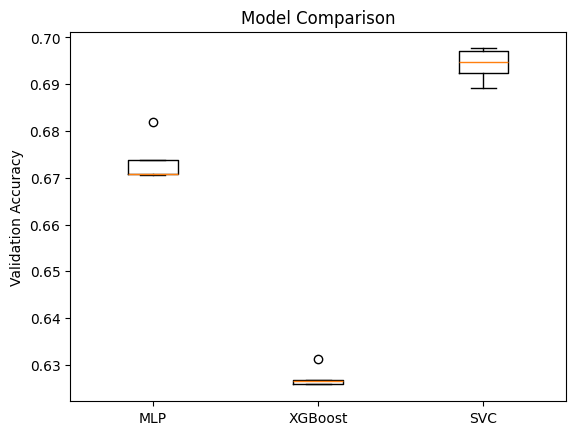

In [20]:
# Plot the results
plt.boxplot([mlp_scores, xgb_scores, svc_scores], labels=['MLP', 'XGBoost', 'SVC'])
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison')
plt.show()

In [ ]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate(X, y, model, param_grid=None):
    scores = []
    ii=0
    for train_index, test_index in tqdm.tqdm(kf.split(X)):
        print(f'Fold {ii}')
        ii+=1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Normalize 
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # PCA
        pca = PCA(n_components=50)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=3)
            grid_search.fit(X_train_pca, y_train)
            model = grid_search.best_estimator_
        else:
            model.fit(X_train_pca, y_train)

        score = model.score(X_test_pca, y_test)
        scores.append(score)

    return scores

# MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [.00001, 0.0001, 0.001, 0.01, .1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter':[200]
}
mlp_scores = train_and_evaluate(embs, labels, MLPClassifier(), mlp_param_grid)

# XGBoost
xgb_scores = train_and_evaluate(embs, labels, GradientBoostingClassifier())

# SVC
svc_param_grid = {
    'C': [1e-2, 0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1e-4, 1e-3, 0.01, 0.1, 1]
}
svc_scores = train_and_evaluate(embs, labels, SVC(), svc_param_grid)

# Plot the results
plt.boxplot([mlp_scores, xgb_scores, svc_scores], labels=['MLP', 'XGBoost', 'SVC'])
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison')
plt.show()

0it [00:00, ?it/s]

Fold 0


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

In [23]:
mlp_scores

[0.6819671145579703,
 0.670634562779932,
 0.6708449815132113,
 0.6708149216941715,
 0.673811098418806]

In [ ]:
np.mean([0.6819671145579703,
 0.670634562779932,
 0.6708449815132113,
 0.6708149216941715,
 0.673811098418806])

In [16]:
# xgb_scores

np.mean([0.6311660203805574,
 0.6257853127724171,
 0.6258454324104968,
 0.6268374064388132,
 0.6265556423976433])

np.float64(0.6272379628799856)

In [21]:
svc_scores

[0.6970270838969549,
 0.6947725974689632,
 0.6892716505846634,
 0.6924579914028918,
 0.6976492514880057]

In [17]:
np.mean([0.6970270838969549,
 0.6947725974689632,
 0.6892716505846634,
 0.6924579914028918,
 0.6976492514880057])

np.float64(0.6942357149682958)

In [19]:
dftte.TCR[0]

'CASSQEGLAGASQYF'

In [11]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example data
# Replace 'embs' and 'labels' with your actual data

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to store accuracy scores
accuracy_scores = []

# Iterate through each fold
for ii, (train_index, test_index) in enumerate(kf.split(embs)):
    print('==========================================================')
    print(f'Fold {ii}')
    X_train, X_test = embs[train_index], embs[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train_pca, y_train)

    y_pred = svm.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

print("5-fold CV Accuracy Scores:", accuracy_scores)

Fold 0


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

Fold 1


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

Fold 2


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

Fold 3


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

Fold 4


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

5-fold CV Accuracy Scores: [0.61956293023116, 0.6173084438031683, 0.6157152733940542, 0.6174286830793279, 0.6172969398184333]


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
dct_te = pkl.load(open('./embsbert/epi_test_dct.pkl', 'rb'))
embs_te = dct_te['joint_full']
labels_te = dfete

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(embs, labels, test_size=0.2, random_state=42)

# Normalize -> PCA -> SVR Pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svr', SVR(kernel='rbf'))
])

# Fit and predict
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

# Since SVR is a regressor, convert predictions to binary labels for classification metrics
y_pred_svr_binary = (y_pred_svr > 0.5).astype(int)

# Metrics for SVR
accuracy_svr = accuracy_score(y_test, y_pred_svr_binary)
rocauc_svr = roc_auc_score(y_test, y_pred_svr_binary)
f1_svr = f1_score(y_test, y_pred_svr_binary)

print("SVR Metrics:")
print(f"Accuracy: {accuracy_svr:.4f}")
print(f"ROC AUC: {rocauc_svr:.4f}")
print(f"F1 Score: {f1_svr:.4f}")

# Normalize -> PCA -> Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

# Fit and predict
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

# Metrics for Logistic Regression
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
rocauc_logreg = roc_auc_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"ROC AUC: {rocauc_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")

/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: Futur

SVR Metrics:
Accuracy: 0.6809
ROC AUC: 0.6809
F1 Score: 0.6624


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Logistic Regression Metrics:
Accuracy: 0.6283
ROC AUC: 0.6283
F1 Score: 0.6269


/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/prad/miniforge3/envs/pt251/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


<Axes: >

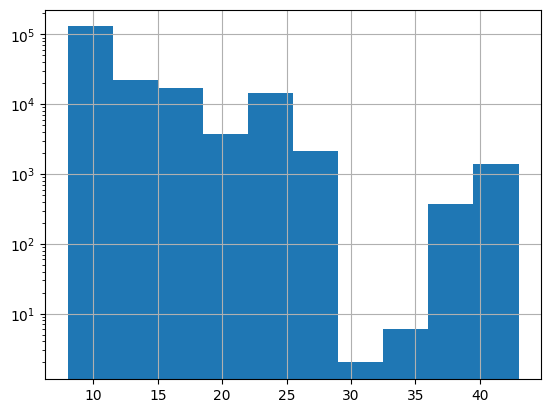

In [8]:
dfttr.Epitope.str.len().hist(log=True)

In [9]:
lenofseq = max(dfho_tcr.TCR.str.len())+max(dfho_tcr.Epitope.str.len())+3
ml = lenofseq*2-1 

In [10]:
np.argwhere(np.array([len(j) for j in joint])==67)

NameError: name 'joint' is not defined

In [90]:
tokenizer(joint, return_tensors='pt', padding='max_length', max_length=67)['attention_mask'][110]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:

tokenizer(joint[110], return_tensors='pt')['input_ids']

tensor([[25, 25,  9, 13, 13,  5,  6,  5, 13, 14, 16, 11,  2,  2, 11,  5,  8,  4,
          6,  8, 19, 18, 24,  2, 13, 18,  5, 12,  4, 14, 15, 12, 17, 18, 24, 24]])

In [114]:
joint[110].replace(' |', '')+' |'

'* C A A S T S A V L G K K G S Q E T Q Y F K A F S P E V I P M F |'

In [117]:
tokenizer(joint[110].replace(' |', ''), return_tensors='pt', max_length=67, padding='max_length')['input_ids']

tensor([[25, 25,  9, 13, 13,  5,  6,  5, 13, 14, 16, 11,  2,  2, 11,  5,  8,  4,
          6,  8, 19, 18,  2, 13, 18,  5, 12,  4, 14, 15, 12, 17, 18, 24, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]])

In [119]:
tokenizer(joint[110].replace(' |', ''), return_tensors='pt', max_length=67, padding='max_length')['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [142]:
tokenizer(joint[110+10].replace(' |', '').replace('* ', ''), return_tensors='pt', max_length=67, padding='max_length')['input_ids']

tensor([[25,  9, 13,  5,  5, 16, 11, 16,  3,  4,  6,  8, 19, 18,  2, 13, 18,  5,
         12,  4, 14, 15, 12, 17, 18, 24, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]])

In [143]:
asdf = tokenizer(joint[110+10].replace(' |', '').replace('* ', ''), return_tensors='pt',)['input_ids']
asdf

tensor([[25,  9, 13,  5,  5, 16, 11, 16,  3,  4,  6,  8, 19, 18,  2, 13, 18,  5,
         12,  4, 14, 15, 12, 17, 18, 24]])

In [138]:
qwer = tokenizer(joint[110+10].replace(' |', '').replace('* ', ''), return_tensors='pt', max_length=67, padding='max_length')['attention_mask']
qwer

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [97]:
tokenizer(joint[110][:43], return_tensors='pt')['input_ids']

tensor([[25, 25,  9, 13, 13,  5,  6,  5, 13, 14, 16, 11,  2,  2, 11,  5,  8,  4,
          6,  8, 19, 18, 24, 24]])

In [91]:
tokenizer(joint[110], return_tensors='pt')['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

42it [00:09,  4.37it/s]

KeyboardInterrupt



In [145]:
del epitope_train_dct

NameError: name 'epitope_train_dct' is not defined

In [10]:
pkl.dump(epitope_train_dct, open('epi_train_dct.pkl', 'wb'), )

In [11]:
epitope_train_dct.keys()

dict_keys(['joint_full', 'epi_full', 'tcr_full', 'joint_pooled', 'epi_pooled', 'tcr_pooled'])

In [71]:
epitope_train_dct['joint_full'][100][:10]

NameError: name 'epitope_train_dct' is not defined

In [9]:
import pickle as pkl


In [87]:
asdf = bmod(**btok('random testing', return_tensors='pt'))

In [89]:
asdf.last_hidden_state.shape

torch.Size([1, 4, 768])

In [90]:
asdf.pooler_output.shape

torch.Size([1, 768])

In [73]:
embs = []

dl = DataLoader(ds, shuffle=False, batch_size=128)


for ii in tqdm.tqdm(range(len(ds))):
    epi, tcr, label = ds[ii]
    seqs = cls_sep_sep_proc_for_tokenize_tcrbert({'Epitopes':[epi], 'TCR': [tcr]}, tokenizer)

    with torch.no_grad():
        tokenized = tokenizer(seqs, return_tensors='pt')
        tokenized = {key:value.to('cuda') for key, value in tokenized.items()}
        outputs = model(**tokenized)
    # break  

tokenized

  1%|▍                                     | 627/48042 [00:03<04:47, 165.02it/s]

KeyboardInterrupt



In [60]:
for ii, batch in tqdm.tqdm(range(len)

SyntaxError: unexpected EOF while parsing (1006591627.py, line 1)

In [30]:
def get_embeddings_for_dataset(dataframe:pd.DataFrame, tokenizer, model):
    ds = BindingDataset(dataframe)
    ds = ds.return_as_datasets()          


In [5]:
ii=0
batch_size=128

dataframe = dftte
ds = BindingDataset(dataframe)
ds = ds.return_as_datasets()

from torch.utils.data import DataLoader
dl = DataLoader(ds, shuffle=False, batch_size=32)


NameError: name 'dftte' is not defined

In [28]:
tokenizer('* ' + ' '.join(dftte.Epitope.values[400]))

{'input_ids': [25, 25, 9, 0, 14, 16, 9, 9, 19, 14, 16, 24], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.cls_token

In [ ]:
''' Extract Embeddings for tcr-bert'''

In [90]:

for batch in dl:
    joint_seq_toked = cls_sep_sep_proc_for_tokenize(batch, tokenizer)
    epi_seqs, tcr_seqs = single_sep_proc_for_tokenize(batch, tokenizer)
    joint_toked = tokenizer(joint_seq_toked, return_tensors='pt')
    break
    

In [89]:
with torch.no_grad():
    epi_toked = tokenizer(epi_seqs, return_tensors='pt')
    embs_epi = model(**epi_toked)    
    
    epi_toked = tokenizer(epi_seqs, return_tensors='pt')
    embs_epi = model(**epi_toked)    

In [92]:
import torch
with torch.no_grad():
    joint_toked = tokenizer(joint_seq_toked, return_tensors='pt')
    joint_embs = model(**joint_toked)

In [96]:
joint_embs.last_hidden_state.shape

torch.Size([32, 7, 768])

In [151]:
bert_pengfei_dir = '/home/prad/ASU Dropbox/Pradyumna Kadambi/BERT-Base-TCR'
tokenizer = BertTokenizer.from_pretrained(bert_pengfei_dir, do_lower_case=False )
model = BertModel.from_pretrained(bert_pengfei_dir)



In [ ]:
dftt

In [163]:
tokenizer(_seqs[1], return_tensors='pt')['input_ids']

tensor([[2, 1, 3]])

In [164]:
_seqs[0]

'CASSQEGLAGASQYF'

In [165]:
_seqs[1]

'CASSQETDIVFNOPQHF'

In [145]:
import re
import numpy as np
epi_seqs_sub = np.array([re.sub(r'[UZOB]', 'x', seq) for seq in epi_seqs])

In [ ]:
[ep]

In [110]:
with torch.no_grad():
#     joint_toked = tokenizer.encode_plus(joint_seq_toked, return_tensors='pt', add_special_tokens=True)
    joint_toked = tokenizer(joint_seq_toked, return_tensors='pt', add_special_tokens=True)
    joint_embs = model(**joint_toked)

In [113]:
tokenizer.encode_plus(joint_seq_toked, return_tensors='pt')

{'input_ids': tensor([[25, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
embs

In [115]:
from transformers import AutoTokenizer
btok = AutoTokenizer.from_pretrained('bert-base-uncased')

In [117]:
btok('[cls]Hello World!')

{'input_ids': [101, 1031, 18856, 2015, 1033, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# apply pca


In [ ]:
cross attention module

In [124]:
btok('[CLS] Hello World! [SEP]')

{'input_ids': [101, 101, 7592, 2088, 999, 102, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [125]:
tokenizer(batch['Epitopes'][0])

{'input_ids': [25, 23, 24], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [127]:
tokenizer.special_tokens_map

{'unk_token': '?',
 'sep_token': '|',
 'pad_token': '$',
 'cls_token': '*',
 'mask_token': '.'}

In [131]:
tokenizer(f"{batch['Epitopes'][0]}")

{'input_ids': [25, 23, 24], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [130]:
tokenizer(f"[cls]{batch['Epitopes'][0]}")

{'input_ids': [25, 23, 23, 23, 23, 24], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [63]:
embs.last_hidden_state.shape

torch.Size([32, 7, 768])

In [44]:
print(outs['input_ids'][0])
print(outs['input_ids'][0])
print(outs['input_ids'][0])

[25, 25, 23, 24, 24]


In [ ]:
print()

In [39]:
outs = tokenizer(epi_seqs)

In [ ]:
''' Extract Embeddings for t5'''

In [ ]:
for ii in range:

In [13]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
t5tokenizer = T5Tokenizer.from_pretrained('dkarthikeyan1/tcrt5_pre_tcrdb')
tcrt5 = T5ForConditionalGeneration.from_pretrained("dkarthikeyan1/tcrt5_pre_tcrdb")
pmhc = "[PMHC]KLGGALQAK[SEP]YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY[EOS]"
encoded_pmhc = t5tokenizer(pmhc, return_tensors='pt')

# Can be useful for classification/regression downstream tasks
enc_outputs = tcrt5.encoder(**encoded_pmhc)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'TCRT5Tokenizer'. 
The class this function is called from is 'T5Tokenizer'.
/home/prad/anaconda3/envs/tcrbert/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/home/prad/anaconda3/envs/tcrbert/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/home/prad/anaconda3/envs/tcrbert/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:818